In [1]:
%cd ~/github/agn_lf/
import source.astro_functions as af
import source.table_functions as tf
import source.lf_xi2 as xi2
import source.vmax as vmax
import source.utils as utils
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.table as table
import astropy.units as u
import importlib
from sklearn.neighbors import KernelDensity

/Users/runburg/github/agn_lf


In [2]:
xservs_catalog = table.Table.read('./data/tableA.v01.fits')
xservs_catalog = xservs_catalog[(xservs_catalog['ZPHOT'] > 0 ) | (xservs_catalog['ZSPEC'] > 0)]

cosmo = af.setup_cosmology()

In [3]:
z_sample_min = 0.5
z_sample_max = 4
l_sample_min = 3e42 #erg/s
l_sample_max = 3e46 #erg/s 

num_bins_z = 10
num_bins_l = 15
# redshift range 
z_bins = np.logspace(np.log10(z_sample_min), np.log10(z_sample_max), num=num_bins_z)
# print(z_bins)
l_bins = np.logspace(np.log10(l_sample_min), np.log10(l_sample_max), num=num_bins_l)

flux_limit = 6.5e-15

image_file = './data/chen2018-xmmlss-data-products-2018-06-08/xexp_merged.full.v01.fits'
wcs, hdu = utils.load_wcs(image_file)
cov_function = vmax.coverage_function(hdu.data, wcs, 3824, 2694, detector_area=36, photon_energy=7e-9)

full_fluxes = xservs_catalog['FB_FLUX']
goodzs = (xservs_catalog['ZPHOT'] > 0) & (xservs_catalog['ZSPEC'] > 0)
difs = xservs_catalog['ZPHOT'][goodzs] - xservs_catalog['ZSPEC'][goodzs]

kds = []
for i in np.arange(len(z_bins)-1):
    inbin = (xservs_catalog['ZPHOT'][goodzs] > z_bins[i]) & (xservs_catalog['ZPHOT'][goodzs] < z_bins[i+1])
    kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
    kde.fit(xservs_catalog['ZSPEC'][goodzs][inbin][:, None])
    
    kds.append(kde)
    
spectral_index = 1.7
bolo_corr = 1
# bolo_corr = 12

N = 1000


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 35.5  -4.8  
CRPIX : 1969.0  1267.0  
CD1_1 CD1_2  : -0.001111111111111  0.0  
CD2_1 CD2_2  : 0.0  0.001111111111111  
NAXIS : 3824  2694


/Users/runburg/github/agn_lf/source/vmax.py:200: RuntimeWarning: divide by zero encountered in true_divide
  fluxes = 1/(data[:-1, :-1]).flatten()


In [4]:
import time
start_time = time.time()
lf_chain = np.zeros((N, num_bins_z-1, num_bins_l-1))
# lf_err_chain = lf_chain[:]

for i in range(N):
    if i % 10 == 0:
        print('progress', round(i/N * 100, 2), '%')
        

    randomz = np.zeros(len(xservs_catalog))
    ### use zphot - ZSPEC to estimate uncertainty on z
#     for j in np.arange(len(z_bins) - 1):
#         inbin = (xservs_catalog['ZPHOT'][goodzs] >= z_bins[j]) & (xservs_catalog['ZPHOT'][goodzs] < z_bins[j+1])
#         histo, bin_edges = np.histogram(difs[inbin], bins=200)

#         photoz_inbin = (xservs_catalog['ZPHOT'] >= z_bins[j]) & (xservs_catalog['ZPHOT'] < z_bins[j+1])
#         randomz[photoz_inbin] = xservs_catalog['ZPHOT'][photoz_inbin] - np.random.choice((bin_edges[:-1]), size=np.sum(photoz_inbin), p=histo/np.sum(histo))
        
#         while np.any(randomz < 0):
#             indices = randomz < 0
#             randomz[indices] = xservs_catalog['ZPHOT'][indices] - np.random.choice((bin_edges[:-1]), size=np.sum(indices), p=histo/np.sum(histo))

    for j, kd in enumerate(kds):
        photoz_inbin = (xservs_catalog['ZPHOT'] >= z_bins[j]) & (xservs_catalog['ZPHOT'] < z_bins[j+1])
        randomz[photoz_inbin] = kd.sample(np.sum(photoz_inbin)).flatten()
        
    xservs_catalog['random_z'] = randomz
    z = np.array([row['ZSPEC'] if row['ZSPEC'] > 0 else row['random_z'] for row in xservs_catalog])  
#     z = np.array([row['ZSPEC'] if row['ZSPEC'] > 0 else np.random.normal(row['ZPHOT'], (row['ZPHOT_UERR'] - row['ZPHOT_LERR'])/2) for row in xservs_catalog])

    l = 4 * np.pi * cosmo.luminosity_distance(z).to(u.cm).value**2 * xservs_catalog['FB_FLUX'] * (1 + z)**(-1 + spectral_index) * bolo_corr

    good_redshift_and_l_selected = (l_sample_min < l) & (l_sample_max > l) & (z_sample_min < z) & (z_sample_max > z)
    l = l[good_redshift_and_l_selected]
    z = z[good_redshift_and_l_selected]
#     print(time.time() - start_time)
    
    coverage_correction = vmax.coverage_correction(full_fluxes, full_fluxes[good_redshift_and_l_selected])
#     print(time.time() - start_time)
    
    zmax = vmax.compute_zmax(l, z, cosmo, flux_limit, zspacing=0.5, jack_version=False, output=False)
    zmin = np.array([0]*len(zmax))
#     print(time.time() - start_time)

    def corrected_cov_func(l, z):
        flux = l / (4 * np.pi * cosmo.luminosity_distance(z).to(u.cm).value**2)
        
        return coverage_correction(flux) * cov_function(flux)

    vmax_vals = vmax.compute_binned_vmax_values(l, (z, zmin, zmax), l_bins, z_bins, cosmo, bin_z_bounds=False, coverage=corrected_cov_func)
#     print(time.time() - start_time)
    
    lf_vals, lf_errs = vmax.compute_lf_values(l, z, vmax_vals, z_bins, l_bins)
#     print(time.time() - start_time)
    
    lf_chain[i] = lf_vals
#     lf_err_chain[i] = lf_errs
    
print(time.time() - start_time)


progress 0.0 %
progress 1.0 %
progress 2.0 %
progress 3.0 %
progress 4.0 %
progress 5.0 %
progress 6.0 %
progress 7.0 %
progress 8.0 %
progress 9.0 %
progress 10.0 %
progress 11.0 %
progress 12.0 %
progress 13.0 %
progress 14.0 %
progress 15.0 %
progress 16.0 %
progress 17.0 %
progress 18.0 %
progress 19.0 %
progress 20.0 %
progress 21.0 %
progress 22.0 %
progress 23.0 %
progress 24.0 %
progress 25.0 %
progress 26.0 %
progress 27.0 %
progress 28.0 %
progress 29.0 %
progress 30.0 %
progress 31.0 %
progress 32.0 %
progress 33.0 %
progress 34.0 %
progress 35.0 %
progress 36.0 %
progress 37.0 %
progress 38.0 %
progress 39.0 %
progress 40.0 %
progress 41.0 %
progress 42.0 %
progress 43.0 %
progress 44.0 %
progress 45.0 %
progress 46.0 %
progress 47.0 %
progress 48.0 %
progress 49.0 %
progress 50.0 %
progress 51.0 %
progress 52.0 %
progress 53.0 %
progress 54.0 %
progress 55.0 %
progress 56.0 %
progress 57.0 %
progress 58.0 %
progress 59.0 %
progress 60.0 %
progress 61.0 %
progress 62.0 %
pr

(1000, 9, 14)


(0.0, 6.726001115747249e-09, 0)

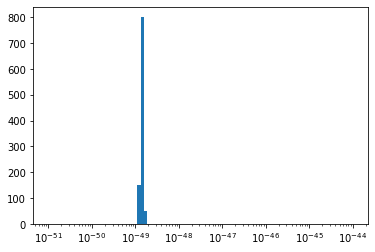

In [5]:
lf_mean = np.mean(lf_chain, axis=0)
lf_mean_err = np.std(lf_chain, axis=0)
# print(lf_mean_err*np.log(10)*(l_bins[1:]-l_bins[:-1])/2)
print(lf_chain.shape)
plt.hist(lf_chain[:, 2, 5], bins=np.logspace(-51, -44, num=100))
ax = plt.gca()
ax.set_xscale('log')
bin_centers = (l_bins[1:]+l_bins[:-1])/2
min(lf_chain[:, 5, -1]), lf_mean[5, -1]*bin_centers[-1]*np.log(10), np.sum(np.isnan(lf_chain))


In [6]:
lit_data={}
aird_lade_params_central = {'A': 10**-4.53, 
                               'gamma1':0.62, 
                               'gamma2':3.01,
                               'Lstar': 10**44.77,
                               'zc':0.75,
                               'p1':6.36,
                               'p2':-0.24,
                               'd':-0.19
                              }
aird_lade_params_min = {'A': 10**-4.46, 
                               'gamma1':0.6, 
                               'gamma2':2.9,
                               'Lstar': 10**44.71,
                               'zc':0.66,
                               'p1':5.96,
                               'p2':-0.51,
                               'd':-.21
                              }
aird_lade_params_max = {'A': 10**-4.6, 
                               'gamma1':0.64, 
                               'gamma2':3.12,
                               'Lstar':10**44.83,
                               'zc':0.84,
                               'p1':6.76,
                               'p2':0.03,
                               'd':-0.17
                              }

center_zbins = (z_bins[1:] + z_bins[:-1]) / 2
ls = np.logspace(43, 45.2, num=50)
aird_mid = af.LADE(ls, center_zbins, **aird_lade_params_central, no_k=True)
aird_high = af.LADE(ls, center_zbins, **aird_lade_params_max, no_k=True)
aird_low = af.LADE(ls, center_zbins, **aird_lade_params_min, no_k=True)
# print(ranalli_mid[0])
lit_data['Aird LADE'] = list(zip(aird_mid, aird_high, aird_low))
# np.array(lit_data['Ranalli LADE'])[0], np.array(lit_data['Aird 2010'])[0]

In [7]:
importlib.reload(utils)
importlib.reload(vmax)
ranalli_lade_params_central = {'A': 10**-3.53, 
                               'gamma1':0.16, 
                               'gamma2':2.48,
                               'Lstar': 10**42.72,
                               'zc':1.72,
                               'p1':4.67,
                               'p2':-0.3,
                               'd':-0.29
                              }
ranalli_lade_params_min = {'A': 10**-3.65, 
                               'gamma1':0.09, 
                               'gamma2':2.37,
                               'Lstar': 10**42.65,
                               'zc':1.53,
                               'p1':4.35,
                               'p2':-0.91,
                               'd':-0.31
                              }
ranalli_lade_params_max = {'A': 10**-3.48, 
                               'gamma1':0.23, 
                               'gamma2':2.6,
                               'Lstar':10**42.82,
                               'zc':1.93,
                               'p1':5.0,
                               'p2':0.02,
                               'd':-0.26
                              }

center_zbins = (z_bins[1:] + z_bins[:-1]) / 2
ls = np.logspace(43, 45.2, num=50)
ranalli_mid = af.LADE(ls, center_zbins, **ranalli_lade_params_central)
ranalli_high = af.LADE(ls, center_zbins, **ranalli_lade_params_max)
ranalli_low = af.LADE(ls, center_zbins, **ranalli_lade_params_min)
# print(ranalli_mid[0])
lit_data['Ranalli LADE'] = list(zip(ranalli_mid, ranalli_high, ranalli_low))
# np.array(lit_data['Ranalli LADE'])[0], np.array(lit_data['Aird 2010'])[0]

/Users/runburg/github/agn_lf/source/vmax.py:242: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))


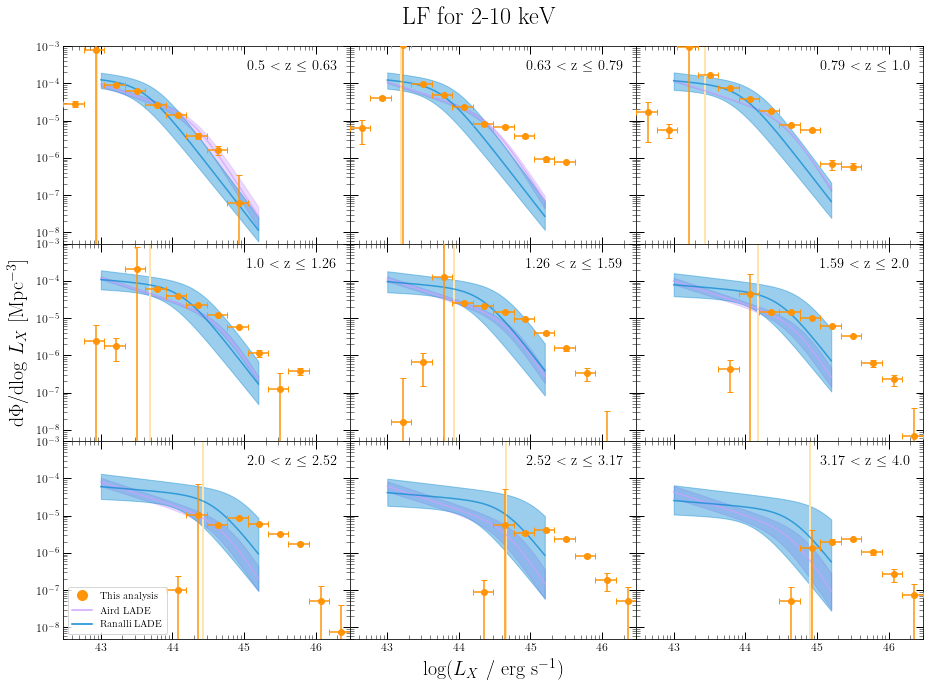

In [8]:
import importlib
importlib.reload(vmax)

np.savez('./output/lf_xray_montecarlo.npz', lf_vals=lf_mean, lf_errs=lf_mean_err)

l_limits = 4 * np.pi * cosmo.luminosity_distance((z_bins[:-1]+z_bins[1:])/2)**2 * flux_limit/(u.cm**2)
l_limits = l_limits.decompose()
fig, axs, big_ax = vmax.plot_lf_vmax(lf_mean, lf_mean_err, z_bins, l_bins, lum_limits=l_limits, \
                                     compare_to_others=lit_data, title='LF for 2-10 keV', \
                                     outfile='./output/xray_lf.pdf', lum_sublabel='_X')

In [9]:
l = np.logspace(np.log10(l_sample_min), np.log10(l_sample_max), num=20)
z = np.linspace(z_sample_min, z_sample_max, num=20)
corrected_cov_func(l, z)


array([3.01211566, 1.95867653, 1.54949218, 1.60018556, 1.97229314,
       2.55661685, 3.21693949, 3.67058439, 4.08846704, 4.70735346,
       5.48914793, 6.02676781, 6.50439599, 6.61369293, 7.08057321,
       7.04763299, 7.35813386, 6.86284399, 5.66800342, 4.73065768])